#Интеграция. Итоговый проект/server

#Step 1 - TRAIN

### Обучение пайплайна

1. Загрузим данные https://www.kaggle.com/datasets/russellyates88/suicide-rates-overview-1985-to-2016
2. Соберем пайплайн с простейшим препроцессингом данных
3. Обучим градиентный бустинг и сохраним на диск предобученный пайплайн

In [1]:
import pandas as pd 
import dill
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
#from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

#visualisation
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#metrics
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

#normalizing data
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

#pipeline
from sklearn.pipeline import Pipeline, FeatureUnion

#imputer
from sklearn.impute import SimpleImputer

import sklearn.datasets

import warnings
warnings.filterwarnings('ignore')

In [2]:

def str_to_num(str_a):
    """Перевод строки из цифр и знаков препинания в число"""
    if type(str_a) == str and ',' in str_a:
        b_num = int(str_a.replace(',',''))
        #print(b)
    elif type(str_a) == str and '.' in str_a:
        b_num = float(str_a)
        
    elif type(str_a) == str:
        b_num = int(str_a)
        
    else:
        b_num = str_a
    return b_num


In [3]:
# Пути к директориям и файлам:
REPORTS_FILE_PATH = './reports/'

In [4]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 250], [0, 250], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

Загрузим данные

Ссылка на google drive:https://drive.google.com/file/d/1QLC9wmCeB88ZtMbhsyIWoEUeV_Yv7pwN

In [5]:
!wget 'https://drive.google.com/uc?export=download&id=1QLC9wmCeB88ZtMbhsyIWoEUeV_Yv7pwN' -O suicide-rates-overview.csv

--2022-04-20 04:39:07--  https://drive.google.com/uc?export=download&id=1QLC9wmCeB88ZtMbhsyIWoEUeV_Yv7pwN
Resolving drive.google.com (drive.google.com)... 173.194.216.101, 173.194.216.138, 173.194.216.102, ...
Connecting to drive.google.com (drive.google.com)|173.194.216.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-9s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/2rnsh91vd24he4l75op7lu4suf79p124/1650429525000/11422071002972207359/*/1QLC9wmCeB88ZtMbhsyIWoEUeV_Yv7pwN?e=download [following]
--2022-04-20 04:39:08--  https://doc-0s-9s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/2rnsh91vd24he4l75op7lu4suf79p124/1650429525000/11422071002972207359/*/1QLC9wmCeB88ZtMbhsyIWoEUeV_Yv7pwN?e=download
Resolving doc-0s-9s-docs.googleusercontent.com (doc-0s-9s-docs.googleusercontent.com)... 74.125.141.132, 2607:f8b0:400c:c06::84
Connecting to doc-0s-9s-docs.googleusercontent.com (doc-0s-9s-

In [6]:
df_temp = pd.read_csv("./suicide-rates-overview.csv")
df_temp.head(3)

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X


In [7]:
target = df_temp['suicides/100k pop']
df = df_temp.drop('suicides/100k pop', axis=1)
df.head()

,country,year,sex,age,suicides_no,population,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,Albania1987,NaN,"2,156,624,900",796,Boomers


Обзор количественных признаков:

In [8]:
df.describe()

,year,suicides_no,population,HDI for year,gdp_per_capita ($)
count,27820.000000,27820.000000,2.782000e+04,8364.000000,27820.000000
mean,2001.258375,242.574407,1.844794e+06,0.776601,16866.464414
std,8.469055,902.047917,3.911779e+06,0.093367,18887.576472
min,1985.000000,0.000000,2.780000e+02,0.483000,251.000000
25%,1995.000000,3.000000,9.749850e+04,0.713000,3447.000000
50%,2002.000000,25.000000,4.301500e+05,0.779000,9372.000000
75%,2008.000000,131.000000,1.486143e+06,0.855000,24874.000000
max,2016.000000,22338.000000,4.380521e+07,0.944000,126352.000000


Обзор номинативных признаков:

In [9]:
for cat_colname in df.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

country

Mauritius                 382
Austria                   382
Netherlands               382
Iceland                   382
Brazil                    372
                         ... 
Bosnia and Herzegovina     24
Cabo Verde                 12
Dominica                   12
Macau                      12
Mongolia                   10
Name: country, Length: 101, dtype: int64
****************************************************************************************************

sex

male      13910
female    13910
Name: sex, dtype: int64
****************************************************************************************************

age

15-24 years    4642
35-54 years    4642
75+ years      4642
25-34 years    4642
55-74 years    4642
5-14 years     4610
Name: age, dtype: int64
****************************************************************************************************

country-year

Albania1987     12
Poland1993      12
Panama2009      12
Panama2010      12
Panama2011    

Наличие пропусков в данных:

In [10]:
df.isnull().sum()

country                   0
year                      0
sex                       0
age                       0
suicides_no               0
population                0
country-year              0
HDI for year          19456
 gdp_for_year ($)         0
gdp_per_capita ($)        0
generation                0
dtype: int64

In [11]:
target.isnull().sum()

0

Разделим данные на train/test и сохраним тестовую выборку на диск:

In [12]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, target, random_state=42)

# save test
X_test.to_csv("X_test.csv", index=None)
y_test.to_csv("y_test.csv", index=None)

# save train
X_train.to_csv("X_train.csv", index=None)
y_train.to_csv("y_train.csv", index=None)

In [13]:
# соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    

class StrToNum():
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in X.columns]
        return self

    def transform(self, X):
        temp = []
        for i in X[self.key]:
          str_1 = str_to_num(i)
          temp.append(str_1)
        X[self.key] = pd.DataFrame(data = temp, index = X.index)
        return X[self.columns]


class OHEEncoderBin(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        B = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        self.columns = B[:1]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
    
        return X[self.columns ]  


class NumericPower(BaseEstimator, TransformerMixin):
    def __init__(self, key, p = 2):
        self.key = key
        self.columns = []
        self.p = p+1

    def fit(self, X, y=None):
        B = [self.key+str(i) for i in range(1,self.p) ]
        self.columns = B+['log']
        return self

    def transform(self, X):
        Xp = X.values.reshape(-1,1)
        for i in range(2, self.p):
            Xp = np.hstack([Xp,(X.values.reshape(-1,1) ** i).astype(float)])

        Xp = np.hstack([Xp, np.log((X.values.reshape(-1,1) + 1).astype(float))])    
        B = pd.DataFrame(data = Xp, index = X.index,columns =[self.columns] )
        return B[self.columns ]   


class MyOrdinalEncoder(TransformerMixin):
    def __init__(self, *args, **kwargs):
        self.encoder = OrdinalEncoder(*args, **kwargs)
    def fit(self, x, y=0):
        self.encoder.fit(x.values.reshape(-1,1))
        return self
    def transform(self, x, y=0):
        return self.encoder.transform(x.values.reshape(-1,1))





Выделяем категориальные и численные колонки для различных предобработок:

In [14]:
df.select_dtypes(include='object').columns

Index(['country', 'sex', 'age', 'country-year', ' gdp_for_year ($) ',
       'generation'],
      dtype='object')

In [15]:
df.select_dtypes(include=['int','float']).columns

Index(['year', 'suicides_no', 'population', 'HDI for year',
       'gdp_per_capita ($)'],
      dtype='object')

In [16]:
categorical_columns = ['country', 'age', 'country-year', 'generation' ]
continuous_columns = ['year', 'suicides_no', 'population', 'HDI for year', 'gdp_per_capita ($)']
cat_to_cont_columns = [' gdp_for_year ($) ']
categorical_bin_columns = ['sex']

Создаем трансформеры:

In [17]:
# под каждый признак создаём трансформер и объединяем их в список
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', MyOrdinalEncoder())
            ])
    final_transformers.append((cat_col, cat_transformer))


for cat_to_cont_col in cat_to_cont_columns:
    cat_to_cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cat_to_cont_col)),
                ('str_to_num', StrToNum(key=cat_to_cont_col))
            ])
    final_transformers.append((cat_to_cont_col, cat_to_cont_transformer))


for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('pow_2', NumericPower(key=cont_col, p=3)),
                ('Scale', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))


for bin_col in categorical_bin_columns:
    bin_transformer = Pipeline([
                ('selector', FeatureSelector(column=bin_col)),
                ('ohe', OHEEncoderBin(key=bin_col))
            ])
    final_transformers.append((bin_col, bin_transformer))

In [18]:
final_transformers

[('country', Pipeline(steps=[('selector', FeatureSelector(column='country')),
                  ('ohe', <__main__.MyOrdinalEncoder object at 0x7f5a7a79cf90>)])),
 ('age', Pipeline(steps=[('selector', FeatureSelector(column='age')),
                  ('ohe', <__main__.MyOrdinalEncoder object at 0x7f5a7a7a70d0>)])),
 ('country-year',
  Pipeline(steps=[('selector', FeatureSelector(column='country-year')),
                  ('ohe', <__main__.MyOrdinalEncoder object at 0x7f5a7a7a71d0>)])),
 ('generation',
  Pipeline(steps=[('selector', FeatureSelector(column='generation')),
                  ('ohe', <__main__.MyOrdinalEncoder object at 0x7f5a7a7a72d0>)])),
 (' gdp_for_year ($) ',
  Pipeline(steps=[('selector', NumberSelector(key=' gdp_for_year ($) ')),
                  ('str_to_num', <__main__.StrToNum object at 0x7f5a7a7a73d0>)])),
 ('year', Pipeline(steps=[('selector', NumberSelector(key='year')),
                  ('pow_2', NumericPower(key='year', p=4)),
                  ('Scale', Sta

In [19]:
feats = FeatureUnion(final_transformers)

pipeline = Pipeline([
    ('features', feats),
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('regressor', GradientBoostingRegressor(criterion='squared_error',
                                             max_depth=7,
                                             min_samples_leaf=10,
                                             random_state=42,  
                                             n_estimators=100))
])

In [20]:
# обучим наш пайплайн
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('country',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='country')),
                                                                 ('ohe',
                                                                  <__main__.MyOrdinalEncoder object at 0x7f5a7a79cf90>)])),
                                                ('age',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='age')),
                                                                 ('ohe',
                                                                  <__main__.MyOrdinalEncoder object at 0x7f5a7a7a70d0>)])),
                                                ('country-year',
                                        

In [21]:
# наши прогнозы для обучающей выборки
preds_train = pipeline.predict(X_train)
preds_train

array([ 1.0843193 ,  5.12152827,  1.84788655, ...,  3.48456513,
       -0.00834394,  6.52597152])

R2:	0.997
RMSE:	1.046
MSE:	1.094


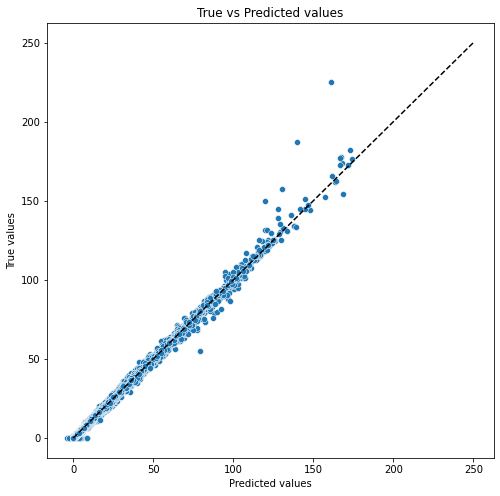

In [22]:
evaluate_preds(y_train, preds_train)

In [23]:
# наши прогнозы для тестовой выборки
preds_test = pipeline.predict(X_test)
preds_test

array([ 0.06259929, 13.58667535,  2.79105635, ..., 13.80027376,
        5.30690773, 30.50460443])

R2:	0.992
RMSE:	1.634
MSE:	2.67


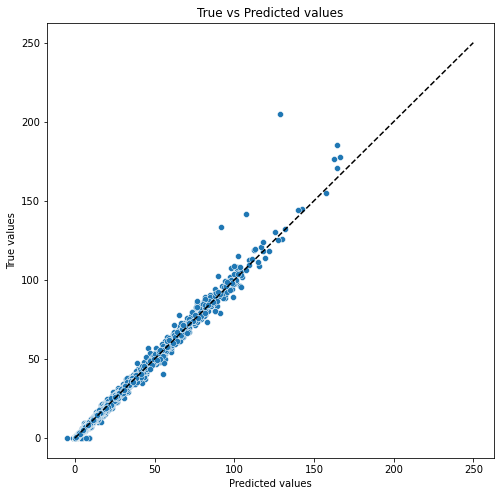

In [24]:
evaluate_preds(y_test, preds_test)

Выделяем признаки с наибольшим влиянием на обучение модели:

In [25]:
pipeline['regressor'].feature_importances_

array([1.20209942e-03, 8.45804732e-03, 2.94411416e-03, 8.23854045e-05,
       4.64873812e-03, 9.56792181e-05, 1.36134262e-04, 5.89816340e-05,
       9.13909555e-05, 9.43465140e-02, 1.85744130e-01, 5.89145854e-02,
       1.20019626e-01, 1.38010928e-01, 1.08697309e-01, 2.11808761e-02,
       1.91528387e-01, 2.39992862e-16, 1.11759899e-17, 1.36583634e-07,
       1.08689402e-05, 3.14389237e-04, 5.23519339e-04, 1.61724386e-03,
       4.14474681e-03, 5.72291691e-02])

In [26]:
feature_importances = pd.DataFrame(zip(X_train.columns, 
                                       pipeline['regressor'].feature_importances_), 
                                       columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)

feature_importances.head(3)

,feature_name,importance
10,generation,0.185744
9,gdp_per_capita ($),0.094347
1,year,0.008458


In [27]:
features = ['generation', 'gdp_per_capita ($)', 'year']
target = target

Соберем кусок, ответственный за feature engineering:

In [28]:
# combine
generation = Pipeline([
                ('selector', FeatureSelector(column='generation')),
                ('ohe', MyOrdinalEncoder())
            ])

gdp_per_capita = Pipeline([
                ('selector', NumberSelector(key='gdp_per_capita ($)')),
                ('pow_2', NumericPower(key='gdp_per_capita ($)', p=3)),
                ('Scale', StandardScaler())
            ])

year = Pipeline([
                ('selector', NumberSelector(key='year')),
                ('pow_2', NumericPower(key='year', p=3)),
                ('Scale', StandardScaler())
            ])


feats_1 = FeatureUnion([('generation', generation),
                      ('gdp_per_capita ($)', gdp_per_capita),
                      ('year', year)])

Добавим регрессор:

In [29]:
%%time

pipeline_1 = Pipeline([
    ('features', feats_1),
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('regressor', GradientBoostingRegressor(criterion='squared_error',
                                             max_depth=7,
                                             min_samples_leaf=10,
                                             random_state=42,  
                                             n_estimators=100))
])

pipeline_1.fit(X_train, y_train)

CPU times: user 7.65 s, sys: 19.2 ms, total: 7.66 s
Wall time: 7.67 s


Посмотрим, как выглядит наш pipeline:

In [30]:
pipeline_1.steps

[('features', FeatureUnion(transformer_list=[('generation',
                                  Pipeline(steps=[('selector',
                                                   FeatureSelector(column='generation')),
                                                  ('ohe',
                                                   <__main__.MyOrdinalEncoder object at 0x7f5a7a2e4fd0>)])),
                                 ('gdp_per_capita ($)',
                                  Pipeline(steps=[('selector',
                                                   NumberSelector(key='gdp_per_capita '
                                                                      '($)')),
                                                  ('pow_2',
                                                   NumericPower(key='gdp_per_capita '
                                                                    '($)',
                                                                p=4)),
                                          

Сохраним модель (пайплайн):

In [31]:
with open("gboostreg_pipeline.dill", "wb") as f:
    dill.dump(pipeline_1, f)

# Step 2 - PREDICT

### Проверка работоспособности и качества пайплайна

Здесь мы еще не запускаем никакое API, а загружаем модель (pipeline) напрямую и проверяем на отложенной (тестовой) выборке

In [32]:
X_test = pd.read_csv("X_test.csv")
y_test = pd.read_csv("y_test.csv")

In [33]:
X_test.head()

,country,year,sex,age,suicides_no,population,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Netherlands,2015,male,5-14 years,1,987750,Netherlands2015,NaN,"757,999,453,314",47206,Generation Z
1,Sri Lanka,2001,female,75+ years,31,222745,Sri Lanka2001,NaN,"15,749,753,805",912,Silent
2,El Salvador,2013,female,35-54 years,19,748153,El Salvador2013,0.664,"21,977,401,900",3885,Generation X
3,Saint Vincent and Grenadines,1987,female,75+ years,0,1500,Saint Vincent and Grenadines1987,NaN,"175,580,630",1908,G.I. Generation
4,Costa Rica,2003,female,75+ years,0,54020,Costa Rica2003,NaN,"17,195,867,540",4583,Silent


In [34]:
with open('gboostreg_pipeline.dill', 'rb') as in_strm:
    pipeline = dill.load(in_strm)

In [35]:
pipeline

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('generation',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='generation')),
                                                                 ('ohe',
                                                                  <__main__.MyOrdinalEncoder object at 0x7f5a7a20c790>)])),
                                                ('gdp_per_capita ($)',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='gdp_per_capita '
                                                                                     '($)')),
                                                                 ('pow_2',
                                                                  NumericPower(key='gdp_per_capita '
      

In [36]:
preds = pipeline.predict(X_test)

preds[:10]

array([ 0.95403687, 47.70278885, 10.58481745,  7.40664641, 18.00017095,
       18.57460607,  1.09449213,  2.25527128,  7.19659809,  0.71548211])

In [37]:
y_test_ar = np.array(y_test['suicides/100k pop'].tolist())
y_test_ar

array([ 0.1 , 13.92,  2.54, ..., 14.48,  4.85, 30.11])

R2:	0.196
RMSE:	16.905
MSE:	285.769


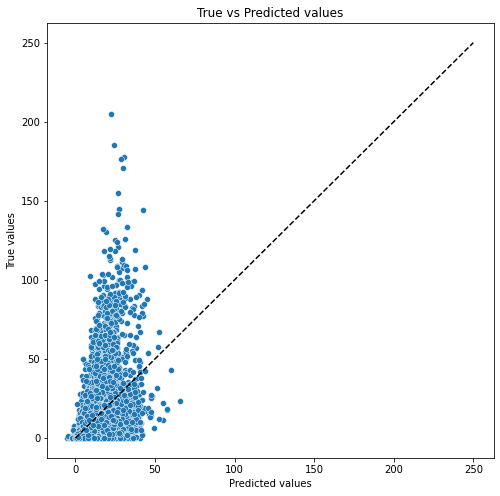

In [38]:
evaluate_preds(y_test_ar, preds)

In [39]:
pred_df = pd.DataFrame({'preds': preds})
pred_df.to_csv("test_predictions.csv", index=None)

# Step 3 - FLASK

In [40]:
!pip install flask-ngrok

In [41]:
from flask_ngrok import run_with_ngrok
from flask import Flask, request, jsonify
import pandas as pd

In [42]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.tgz
!tar -xvf /content/ngrok-stable-linux-amd64.tgz
!./ngrok authtoken 27zEiRZKYnZL0BHmJm4pxro7xiW_78HG1GewnZLj4Q1cZsxGj # insert here your personal Authtoken instead of myne
!./ngrok http 80

--2022-04-20 04:39:57--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.tgz
Resolving bin.equinox.io (bin.equinox.io)... 54.161.241.46, 18.205.222.128, 54.237.133.81, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.161.241.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13770165 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.tgz.1’

ngrok-stable-linux- 100%[===================>]  13.13M  55.3MB/s    in 0.2s    

2022-04-20 04:39:58 (55.3 MB/s) - ‘ngrok-stable-linux-amd64.tgz.1’ saved [13770165/13770165]

ngrok
Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [43]:
# Пробный запуск Flask

app = Flask(__name__)
run_with_ngrok(app)  # Start ngrok when app is run

@app.route("/a")
def hello():
    return "Hello World!"

if __name__ == '__main__':
    app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://5d17-35-237-36-97.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [20/Apr/2022 04:40:12] "GET / HTTP/1.1" 404 -
127.0.0.1 - - [20/Apr/2022 04:40:13] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [20/Apr/2022 04:40:18] "GET /a HTTP/1.1" 200 -


In [44]:
import pandas as pd
import dill

### **Создаем сервис для обработки запросов к модели**

In [45]:
# Загружаем обученные модели
with open('gboostreg_pipeline.dill', 'rb') as in_strm:
    model = dill.load(in_strm)

In [46]:
X_test = pd.read_csv("X_test.csv")
y_test = pd.read_csv("y_test.csv")

In [47]:
# Обработчики и запуск Flask
app = Flask(__name__)
run_with_ngrok(app)  # Start ngrok when app is run


@app.route("/", methods=["GET"])
def general():
    return "Welcome to prediction process"


@app.route('/predict', methods=['POST'])
def predict():
    data = {"success": False}

    # ensure an image was properly uploaded to our endpoint
    generation, gdp_per_capita, year = "", "", ""
    request_json = request.get_json()
    
    if request_json['generation']:
        generation = request_json['generation']
    
    if request_json['gdp_per_capita ($)']:
        gdp_per_capita = request_json['gdp_per_capita ($)']
                
    if request_json['year']:
        year = request_json['year']
    
    print('prediction year: ', year)  
    preds = model.predict(pd.DataFrame({"generation": [generation],
                                        'gdp_per_capita ($)': [gdp_per_capita],
                                        "year": [year]}))
    data["predictions"] = preds[0]
    data["year"] = year
        # indicate that the request was a success
    data["success"] = True
    print('OK')

        # return the data dictionary as a JSON response
    return jsonify(data)


if __name__ == '__main__':
    app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://d930-35-237-36-97.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [20/Apr/2022 04:41:02] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [20/Apr/2022 04:41:22] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [20/Apr/2022 04:43:09] "POST /predict HTTP/1.1" 200 -


prediction year:  1985
OK


127.0.0.1 - - [20/Apr/2022 04:43:44] "POST /predict HTTP/1.1" 200 -


prediction year:  2015
OK


127.0.0.1 - - [20/Apr/2022 04:43:45] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [20/Apr/2022 04:43:45] "POST /predict HTTP/1.1" 200 -


prediction year:  2015
OK
prediction year:  2001
OK


127.0.0.1 - - [20/Apr/2022 04:43:45] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [20/Apr/2022 04:43:45] "POST /predict HTTP/1.1" 200 -


prediction year:  2013
OK
prediction year:  1987
OK


127.0.0.1 - - [20/Apr/2022 04:43:45] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [20/Apr/2022 04:43:45] "POST /predict HTTP/1.1" 200 -


prediction year:  2003
OK
prediction year:  1993
OK


127.0.0.1 - - [20/Apr/2022 04:43:46] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [20/Apr/2022 04:43:46] "POST /predict HTTP/1.1" 200 -


prediction year:  2002
OK
prediction year:  2002
OK


127.0.0.1 - - [20/Apr/2022 04:43:46] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [20/Apr/2022 04:43:46] "POST /predict HTTP/1.1" 200 -


prediction year:  1990
OK
prediction year:  1995
OK


127.0.0.1 - - [20/Apr/2022 04:43:46] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [20/Apr/2022 04:43:47] "POST /predict HTTP/1.1" 200 -


prediction year:  1989
OK
prediction year:  2008
OK


127.0.0.1 - - [20/Apr/2022 04:43:47] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [20/Apr/2022 04:43:47] "POST /predict HTTP/1.1" 200 -


prediction year:  2012
OK
prediction year:  2009
OK


127.0.0.1 - - [20/Apr/2022 04:43:47] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [20/Apr/2022 04:43:47] "POST /predict HTTP/1.1" 200 -


prediction year:  2005
OK
prediction year:  2010
OK


127.0.0.1 - - [20/Apr/2022 04:43:47] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [20/Apr/2022 04:43:48] "POST /predict HTTP/1.1" 200 -


prediction year:  2004
OK
prediction year:  2014
OK


127.0.0.1 - - [20/Apr/2022 04:43:48] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [20/Apr/2022 04:43:48] "POST /predict HTTP/1.1" 200 -


prediction year:  2000
OK
prediction year:  2011
OK


127.0.0.1 - - [20/Apr/2022 04:43:48] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [20/Apr/2022 04:43:48] "POST /predict HTTP/1.1" 200 -


prediction year:  2010
OK
prediction year:  2005
OK


127.0.0.1 - - [20/Apr/2022 04:43:49] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [20/Apr/2022 04:43:49] "POST /predict HTTP/1.1" 200 -


prediction year:  1986
OK
prediction year:  2001
OK


127.0.0.1 - - [20/Apr/2022 04:43:49] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [20/Apr/2022 04:43:49] "POST /predict HTTP/1.1" 200 -


prediction year:  2003
OK
prediction year:  1999
OK


127.0.0.1 - - [20/Apr/2022 04:43:49] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [20/Apr/2022 04:43:49] "POST /predict HTTP/1.1" 200 -


prediction year:  2005
OK
prediction year:  1998
OK


127.0.0.1 - - [20/Apr/2022 04:43:50] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [20/Apr/2022 04:43:50] "POST /predict HTTP/1.1" 200 -


prediction year:  2001
OK
prediction year:  2014
OK


127.0.0.1 - - [20/Apr/2022 04:43:50] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [20/Apr/2022 04:43:50] "POST /predict HTTP/1.1" 200 -


prediction year:  1999
OK
prediction year:  1994
OK


127.0.0.1 - - [20/Apr/2022 04:43:50] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [20/Apr/2022 04:43:51] "POST /predict HTTP/1.1" 200 -


prediction year:  2005
OK
prediction year:  1995
OK


127.0.0.1 - - [20/Apr/2022 04:43:51] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [20/Apr/2022 04:43:51] "POST /predict HTTP/1.1" 200 -


prediction year:  2002
OK
prediction year:  1988
OK


127.0.0.1 - - [20/Apr/2022 04:43:51] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [20/Apr/2022 04:43:51] "POST /predict HTTP/1.1" 200 -


prediction year:  2010
OK
prediction year:  1997
OK


127.0.0.1 - - [20/Apr/2022 04:43:51] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [20/Apr/2022 04:43:52] "POST /predict HTTP/1.1" 200 -


prediction year:  1989
OK
prediction year:  2003
OK


127.0.0.1 - - [20/Apr/2022 04:43:52] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [20/Apr/2022 04:43:52] "POST /predict HTTP/1.1" 200 -


prediction year:  2006
OK
prediction year:  1991
OK


127.0.0.1 - - [20/Apr/2022 04:43:52] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [20/Apr/2022 04:43:52] "POST /predict HTTP/1.1" 200 -


prediction year:  2000
OK
prediction year:  1995
OK


127.0.0.1 - - [20/Apr/2022 04:43:53] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [20/Apr/2022 04:43:53] "POST /predict HTTP/1.1" 200 -


prediction year:  1996
OK
prediction year:  2000
OK


127.0.0.1 - - [20/Apr/2022 04:43:53] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [20/Apr/2022 04:43:53] "POST /predict HTTP/1.1" 200 -


prediction year:  1988
OK
prediction year:  1985
OK


127.0.0.1 - - [20/Apr/2022 04:43:53] "POST /predict HTTP/1.1" 200 -


prediction year:  2010
OK
prediction year:  1985


127.0.0.1 - - [20/Apr/2022 04:43:53] "POST /predict HTTP/1.1" 200 -


OK
